**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

## Hinglish Language model

At Fast.ai we have introduced a new module called fastai.text which replaces the torchtext library that was used in our 2018 dl1 course. The fastai.text module also supersedes the fastai.nlp library but retains many of the key functions.

This is a modified version of notebook from Fast.ai for training IMDB LM. We modified it for training a LM on hinglish tweets.

In [1]:
#sudo apt-get install -y python-qt4
from fastai.text import *
import html

The Fastai.text module introduces several custom tokens.

We will download dataset files from our GCP cloud storage bucket and store it as a single file

In [19]:
DATA_PATH=Path('data/')
DATA_PATH.mkdir(exist_ok=True)

In [20]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/tweets/')
PATH.mkdir(exist_ok=True)

In [21]:
!mkdir data/gcp_files
!gsutil cp -r gs://tweet-archive/outputs_1/* data/gcp_files


mkdir: cannot create directory 'data/gcp_files': File exists
Copying gs://tweet-archive/outputs_1/1-SwH3yjGyaFJeZnTquyeN0unL5hZ1c0H.jsonl...
Copying gs://tweet-archive/outputs_1/1-UA1yOSGzawiW-wlcWhv4-XGfLQEf_56.jsonl... 
Copying gs://tweet-archive/outputs_1/18COaJCOxCNrRPNQNukAF94xEs4_dzDob.jsonl... 
Copying gs://tweet-archive/outputs_1/19LoFdOaNipRyf0mvh6MRoZd7O7DrLrgz.jsonl... 
\ [4 files][125.3 MiB/125.3 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://tweet-archive/outputs_1/1SRCj1Lw-_1cAz7hVSy-AcBScNF6ibzp-.jsonl...
Copying gs://tweet-archive/outputs_1/1X0cmkScgwStDZO4hrB8EaTHeWO5LtlyW.jsonl... 
Copying gs://tweet-archive/outputs_1/1X8U1dBciiDq-32QjhR7QBXUTC01yHI3w.jsonl... 
Copying gs://tweet-archive/outputs_1/1g-6

In [25]:
!cat data/gcp_files/* > data/tweets/tweets_data
!split -l $[$(wc -l tweets_data|cut -d" " -f1) * 75 / 100] tweets_data

split: invalid number of lines: '$['


## Standardize format

In [36]:
CLAS_PATH=Path('data/hin_tweets_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/hin_tweets_lm/')
LM_PATH.mkdir(exist_ok=True)

We have two datasets :
1. Hinglish tweets dataset : Extracted tweets from huge tweet corpus that's hinglish (Around 100k tweets)
2. Hinglish hate speech dataset : A smaller collection of around 3k tweets that are marked as hate speech or not.

## Language model tokens

In this section, we start cleaning up the messy text. There are 3 main activities we need to perform:

1. Clean up tweets to remove URLs, mentions and hashtags, replace emojis with a standard token to make it suitable for Language Modeling. This can be tuned if needed.
2. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
3. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

In [39]:
#pip install emoji
from hinglish_scripts.tweet_processing_utils import get_text_from_tweet
from hinglish_scripts.tweet_tokenizer import TweetsTokenizer

     |################################| 51kB 1.4MB/s eta 0:00:011
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=a3428e763f04c8efa2baf76be664f85414a6bcf22f4ed8d2883102288a41874a
  Stored in directory: /home/gautham/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [41]:
chunksize=24000
#python -m spacy download en
lang='en'

In [42]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [43]:
"""
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer(lang=lang).proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)
"""

def get_texts(df, n_lbls=1, lang='en'):
    if len(df.columns) == 1:
        labels = []
        texts = f'\n{BOS} {FLD} 1 ' + df[0].astype(str)
    else:
        labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
        texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
        for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls+1} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = TweetsTokenizer(lang=lang).proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [44]:
import json
def read_tweets_data(tweets_file):
    with open(tweets_file, mode="r", encoding="utf-8") as f:
        for line in f:
            text = get_text_from_tweet(json.loads(line))
            yield text

In [45]:
df_trn = pd.DataFrame(read_tweets_data(PATH / 'tweets_data_trn'))
df_val = pd.DataFrame(read_tweets_data(PATH / 'tweets_data_val'))

In [46]:
tok_trn, trn_labels = get_texts(df_trn, 1, lang=lang)
tok_val, val_labels = get_texts(df_val, 1, lang=lang)

In [47]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [48]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [49]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy', allow_pickle=True)
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy', allow_pickle=True)

In [50]:
print(TweetsTokenizer().proc_all(['@jdksjdks hdksdjs'], 'en'))
print(TweetsTokenizer().proc_all_mp(partition_by_cores(['@jdksjdks hdksdjs'])))
x = TweetsTokenizer(lang=lang)

[[' ', 'hdksdjs']]
[[' ', 'hdksdjs']]


In [52]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('t_up', 118828),
 ('twitteremoji', 104151),
 (' ', 59277),
 ('xbos', 59277),
 ('xfld', 59277),
 ('.', 28738),
 ('hai', 20116),
 (',', 11092),
 ('ki', 9329),
 ('ko', 7666),
 ('ka', 6773),
 ('ke', 6735),
 ('?', 6478),
 ('se', 6453),
 ('to', 6388),
 ('bhi', 6316),
 ('ho', 6001),
 ('tk_wrep', 5136),
 ('nahi', 5027),
 ('!', 4904),
 ('me', 4659),
 ('k', 4411),
 ('hi', 4370),
 ('aur', 4358),
 ('ye', 4038)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [53]:
max_vocab = 30000
min_freq = 2

In [54]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [55]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

18322

In [56]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [57]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [58]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy', allow_pickle=True)
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy', allow_pickle=True)
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [59]:
vs=len(itos)
vs,len(trn_lm)

(18322, 59277)

## wikitext103 conversion

We are now going to build an english language model for the Hinglish corpus. We could start from scratch and try to learn the structure of the hinglish language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the Hinglish LM. 

In [61]:
# ! wget -nH -r -np -P {DATA_PATH} http://files.fast.ai/models/wt103/

--2019-11-25 08:05:48--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 852 [text/html]
Saving to: 'data/models/wt103/index.html'

models/wt103/index. 100%[===================>]     852  --.-KB/s    in 0s      

2019-11-25 08:05:48 (96.7 MB/s) - 'data/models/wt103/index.html' saved [852/852]

Loading robots.txt; please ignore errors.
--2019-11-25 08:05:48--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2019-11-25 08:05:48 ERROR 404: Not Found.

--2019-11-25 08:05:48--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 852 [text/html]
Saving to: 'data/models/wt103/index.html?C=N;O=D'

models/wt103/index. 100%[===================>]

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

In [62]:
em_sz,nh,nl = 400,1150,3

In [63]:
PRE_PATH = DATA_PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [64]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [65]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [66]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the Hinglish LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown Hinglish tokens that do not exist in wikitext103.

In [67]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [68]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new Hinglish language pytorch model!

## Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the Hinglish LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [116]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [129]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [130]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.8
# orig - 0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [131]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [132]:
learner.model.load_state_dict(wgts)

<All keys matched successfully>

In [133]:
print(torch.cuda.current_device())

0


We set learning rates and fit our Hinglish LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [134]:
lr=1e-4 #0.01
lrs = lr

In [135]:
learner.fit(lrs, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      7.818873   7.353452   0.131768  



[7.353452397327797, 0.1317677128986985]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [136]:
learner.save('lm_last_ft')

In [137]:
learner.load('lm_last_ft')

In [138]:
learner.unfreeze()

In [144]:
# LR - 1e-4
learner.lr_find(start_lr=lrs/3, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                    
    0      4.541611   4.248555   0.389232  



RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	Missing key(s) in state_dict: "0.rnns.0.module.weight_hh_l0", "0.rnns.1.module.weight_hh_l0", "0.rnns.2.module.weight_hh_l0". 

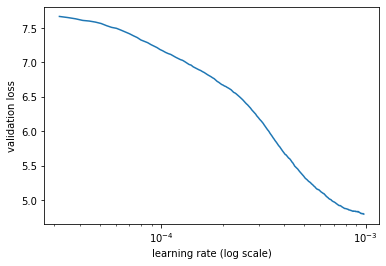

In [142]:
learner.sched.plot()

In [82]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

  5%|▍         | 15/314 [00:07<02:33,  1.95it/s, loss=5.69]


KeyboardInterrupt: 

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [ ]:
learner.save('lm1')

In [ ]:
learner.save_encoder('lm1_enc')

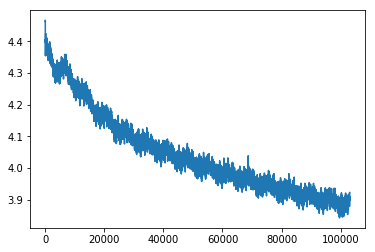

In [ ]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [ ]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [ ]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [ ]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [ ]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [ ]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.

In [ ]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [ ]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [ ]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [ ]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [ ]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [ ]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [ ]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [ ]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [ ]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [ ]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [ ]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [ ]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [ ]:
learn.freeze_to(-1)

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot()

A Jupyter Widget

 80%|███████▉  | 625/782 [01:39<00:24,  6.31it/s, loss=1.28] 

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.365457   0.185553   0.928719  



[0.18555279, 0.9287188090884525]

In [ ]:
learn.save('clas_0')

In [ ]:
learn.load('clas_0')

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.340473   0.17319    0.933125  



[0.17319041, 0.9331253991245995]

In [ ]:
learn.save('clas_1')

In [ ]:
learn.load('clas_1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                      
    0      0.337347   0.186812   0.930782  
    1      0.284065   0.318038   0.932062                      
    2      0.246721   0.156018   0.941747                      
    3      0.252745   0.157223   0.944106                      
    4      0.24023    0.159444   0.945393                      
    5      0.210046   0.202856   0.942858                      
    6      0.212139   0.149009   0.943746                      
    7      0.21163    0.186739   0.946553                      
    8      0.186233   0.1508     0.945218                      
    9      0.176225   0.150472   0.947985                      
    10     0.198024   0.146215   0.948345                      
    11     0.20324    0.189206   0.948145                      
    12     0.165159   0.151402   0.947745                      
    13     0.165997   0.146615   0.947905                      



[0.14661488, 0.9479046703071374]

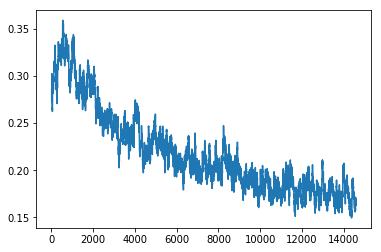

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('clas_2')

The previous state of the art result was 94.1% accuracy (5.9% error). With bidir we get 95.4% accuracy (4.6% error).

## Fin

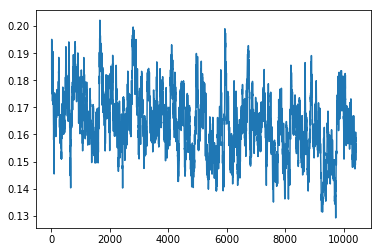

In [ ]:
learn.sched.plot_loss()